## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data.groupby(by='group').agg(['min','max']).date

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
data[['group','purchase','price']].groupby(by='group').agg(['count','sum'])

purchase          price            
         count    sum   count         sum
group                                    
A       147202  17723  147202  1436260000
B       147276  17514  147276  1554100000

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
len(set(data[data.group =='A'].user_id).intersection(set(data[data.group =='B'].user_id)))

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
user_intersection = set(data[data.group =='A'].user_id).intersection(set(data[data.group =='B'].user_id))
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

In [8]:
# Вариант поиска Intersection, с последующим удалением с использованием только pandas функционала
# id1 = pd.Index(data[data.group == 'A'].user_id)
# id2 = pd.Index(data[data.group == 'B'].user_id)
# intersection = id1.intersection(id2)
# data[~data.user_id.isin(intersection)]


In [9]:
# кол-во пересечений через множество
user_intersection.__len__()

1895

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

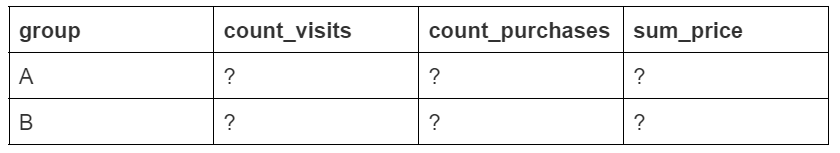
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [10]:
updated_data_grouped = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','purchase':'count_purchases',\
    'price' : 'sum_price'})
updated_data_grouped

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Текущая выборка представлена достаточно большим количеством данных,а именно:
* Группа А - 145307
* Группа Б - 145381

Также обе выборки практически одинаковы по размеру. Разница в размерности составляет около 0.05%, что ничтожно мало.

Так что процентное соотношение выборок можно сказать 50/50 -сбалансированное.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [11]:
# updated_data_grouped[['conversion','mean_check']] = updated_data_grouped.apply(\
#   lambda x: [ x.count_purchases/x.count_visits * 100 ,\
#               x.sum_price/x.count_purchases ,  
# ],axis = 1, result_type='expand' )

updated_data_grouped['conversion'], updated_data_grouped['mean_check'] = zip(\
    *updated_data_grouped.apply(lambda x:\
        [x.count_purchases/x.count_visits * 100,\
         x.sum_price/x.count_purchases], axis=1))
updated_data_grouped

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


In [12]:
round(updated_data_grouped.mean_check)

0    81076.0
1    88665.0
Name: mean_check, dtype: float64

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

На данный момент можно наблюдать что конверсия в группе А незначительно выше, чем в группе B

Что в процентном выражении составляет чуть более 1%

Однако, если мы пронаблюдаем разницу в размере среднего чека, то при немного меньшей конверсии, в группе В размер чека является больше 88665 против 81076, что в процентном выражении  - на 9% средний чек в группе В больше среднего чека группы А.



## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [13]:
updated_data_buytours_corr = pd.pivot_table(updated_data[updated_data.purchase == 1]\
  [['group','purchase','price']],\
  index = 'price', columns='group', aggfunc='count').purchase
updated_data_buytours_corr

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

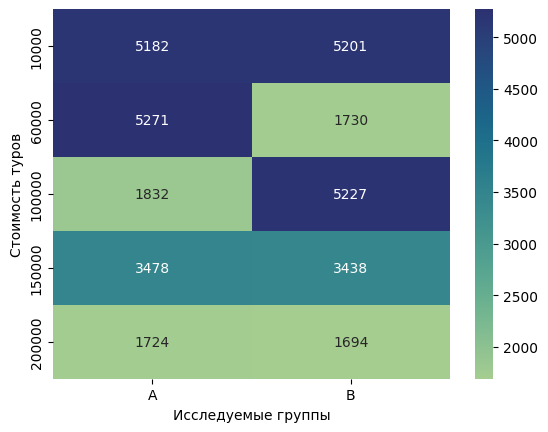

In [14]:
ax = sns.heatmap(
  updated_data_buytours_corr,
  annot=True,
  fmt='.0f',
  cmap='crest')
ax.set(ylabel="Стоимость туров", xlabel="Исследуемые группы");

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Как мы видим из полученных данных (табличных и графика тепловой карты), Туры по цене 10.000, 150.000 и 200.000 в обоих группах были проданы примерно одинаковое кол-во раз.

А вот туры по цене 60.000 и 100.000 проданы с разницей по группам прямо диаметрально, что указывает, что в группе А  тур за 60.000 намного привлекательнее тура за 100.000, в группе же Б все с точностью наоборот.



## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [15]:
updated_data_ext = updated_data.groupby(by=['date','group']).\
  agg({'user_id':'count','purchase':'sum','price':'sum'}).reset_index()

updated_data_ext.rename(columns={'user_id':'visit_counts',
                                 'purchase':'daily_buyed',
                                 'price':'total_amount'}, inplace=True)
  
updated_data_ext[['daily_conv','daily_average_check']] = \
updated_data_ext.apply(lambda x:[\
                          (x.daily_buyed/x.visit_counts)*100,\
                          (x.total_amount/x.daily_buyed)\
                          ],
                          axis = 1,
                          result_type='expand')

display(updated_data_ext[updated_data_ext.date == '2021-01-03'][['group','daily_conv']].round(2))
display(updated_data_ext[updated_data_ext.date == '2021-01-03'][['group','daily_average_check']].round())

,group,daily_conv
2,A,11.34
3,B,11.39


,group,daily_average_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [16]:
updated_data_ext[['cum_visit_counts']] =  updated_data_ext[['group','visit_counts']].groupby('group').cumsum()
updated_data_ext[['cum_daily_buyed']]  =  updated_data_ext[['group','daily_buyed']].groupby('group').cumsum()
updated_data_ext[['cum_total_amount']] =  updated_data_ext[['group','total_amount']].groupby('group').cumsum()

updated_data_ext[['cum_daily_conv','cum_daily_average_check']] = \
updated_data_ext.apply(lambda x:[\
                          (x.cum_daily_buyed/x.cum_visit_counts)*100,\
                          (x.cum_total_amount/x.cum_daily_buyed)\
                          ],
                          axis = 1,
                          result_type='expand')

display(updated_data_ext[(updated_data_ext.group == 'B') \
  & (updated_data_ext.date == '2021-01-20')].cum_daily_conv.round(2).item())

display(updated_data_ext[(updated_data_ext.group == 'A') \
  & (updated_data_ext.date == '2021-01-12')].cum_daily_average_check.round().item())


11.9

81492.0

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

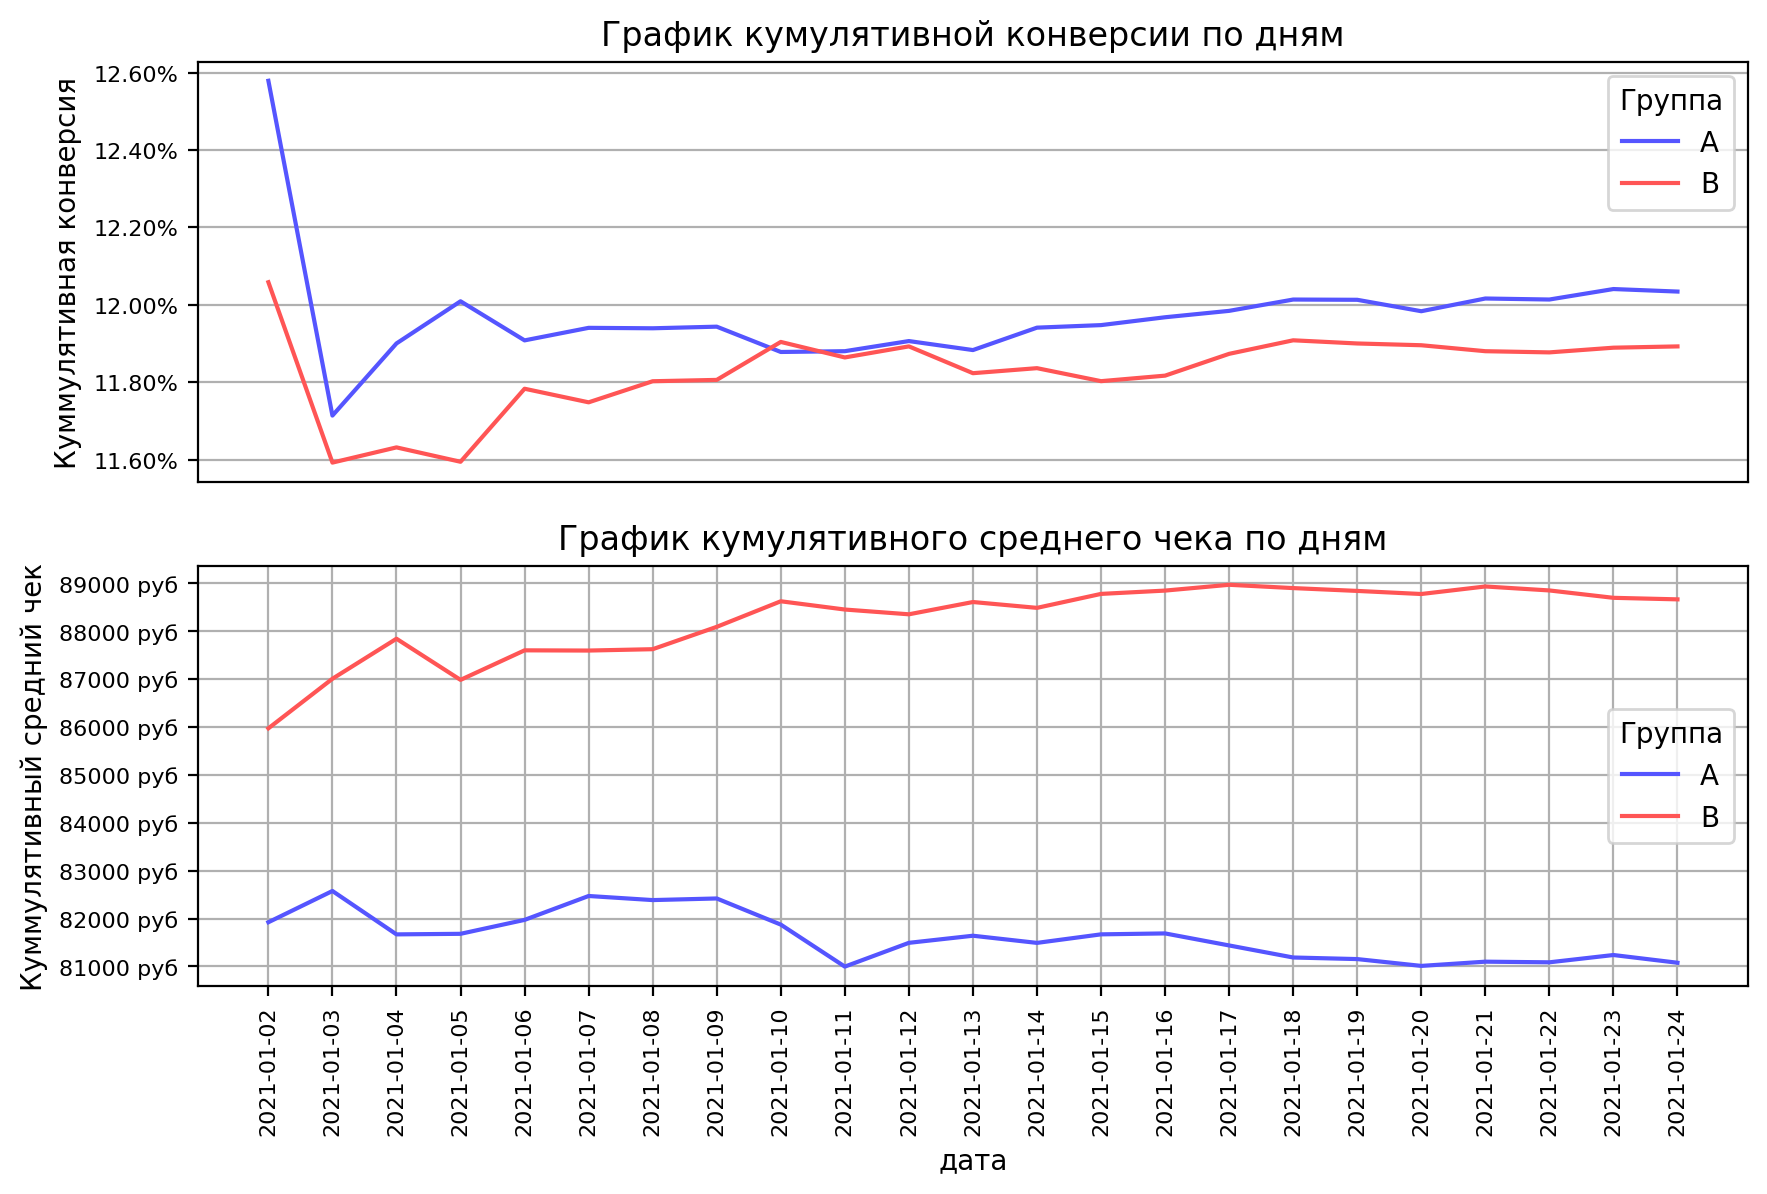

In [17]:
# добавляем систему координат
fig, ax = plt.subplots(2,1, figsize=(10, 6), dpi = 200)
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_daily_conv', data=updated_data_ext, hue='group', ax=ax[0], palette="seismic")
sns.lineplot(x='date', y='cum_daily_average_check', data=updated_data_ext, hue='group', ax=ax[1],
             palette="seismic")
# задаём подпись к графику
ax[0].set_title('График кумулятивной конверсии по дням')
ax[1].set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Куммулятивная конверсия')
ax[0].yaxis.set_major_formatter('{x:1.2f}%')

ax[1].xaxis.set_tick_params(rotation = 90)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[1].tick_params(axis='both', which='major', labelsize=8)
# задаём отображение сетки
ax[0].figure.subplots_adjust(wspace=0, hspace=0.2)

ax[1].set_xlabel('дата')
ax[1].set_ylabel('Куммулятивный средний чек')
ax[1].yaxis.set_major_formatter('{x:.0f} руб')

ax[0].legend(title='Группа')
ax[1].legend(title='Группа')

ax[0].grid(True)
ax[1].grid(True)



Если мы посмотрим на построенный нами куммулятивный график по ежедневной конверсии и по среднему чеку, я бы сказал, что скачки четко наблюдались до 12 января 2021 года для обоих графиков.
Далее графики стабилизировались.

Соответственно, после стабилизации, мы можем наблюдать, что конверсия ненамного, но в Группе А она больше чем в группе Б, примерно на 0.2-0.3%

А вот в разрезе среднего чека, даже в еще нестабилизированном графике Группа Б всегда лидирует. После момента стабилизации, разница примерно составляет около 7 тысяч в день.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [18]:
converted_data = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
# display(converted_data)

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_data['sum'], #число "успехов"
    nobs=converted_data['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Статистическая разница между конверсиями в группах А и Б очень мала, отсюда мы не можем опровергнуть 0-ую гипотезу о том, что конверсии равны.

Так что исходя из этого,статистической разницы между конверсиями - Нету


## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [71]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)
  
  
conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data.group == 'A'].user_id.count(), # размер выборки
x_p=updated_data[updated_data.group == 'A'].purchase.mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data.group == 'B'].user_id.count(), # размер выборки
x_p=updated_data[updated_data.group == 'B'].purchase.mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))  

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)
  
# размеры выборок групп А и B
n = [updated_data[updated_data.group == 'A'].user_id.count(), updated_data[updated_data.group == 'B'].user_id.count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data.group == 'A'].purchase.mean(), updated_data[updated_data.group == 'B'].purchase.mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))  

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. 
То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.
Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

p=0.253
Данные распределены нормально в группе А
p=0.094
Данные распределены нормально в группе B


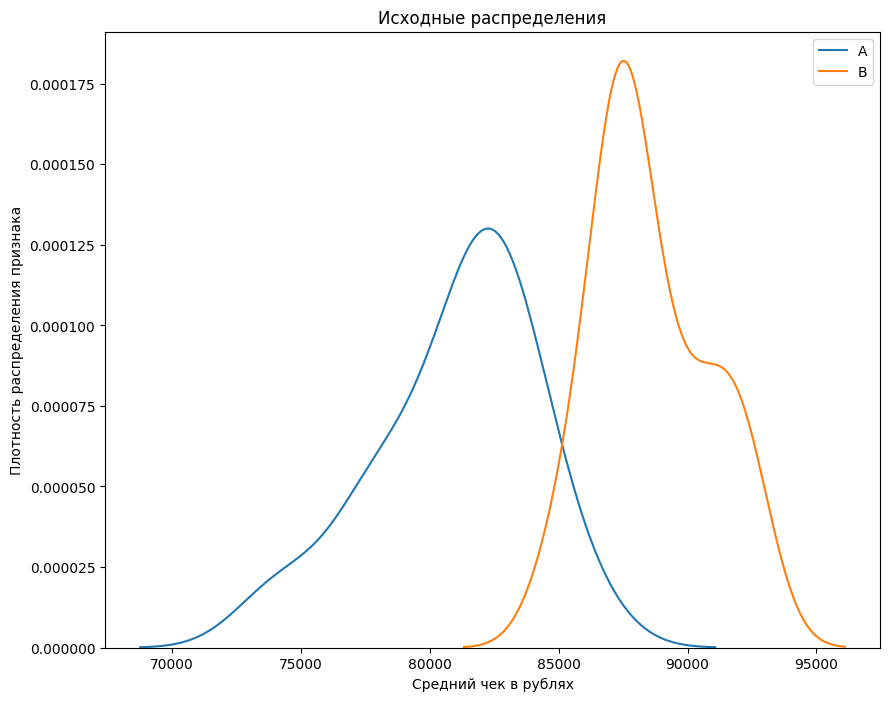

In [44]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

_, p = shapiro(updated_data_ext[updated_data_ext.group == 'A'].daily_average_check)
print('p=%.3f' % p)
# Интерпретация 

if p > alpha:
	print('{} в группе А'.format(H0))
else:
	print('{} в группе А'.format(Ha))

_, p = shapiro(updated_data_ext[updated_data_ext.group == 'B'].daily_average_check)
print('p=%.3f' % p)
# Интерпретация 

if p > alpha:
	print('{} в группе B'.format(H0))
else:
	print('{} в группе B'.format(Ha))

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')
ax1.set(xlabel='Средний чек в рублях', ylabel='Плотность распределения признака')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(updated_data_ext[updated_data_ext.group == 'A'].daily_average_check, ax=ax1, label ='A')
sns.kdeplot(updated_data_ext[updated_data_ext.group == 'B'].daily_average_check, ax=ax1, label ='B')


plt.legend();

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [52]:
H0 = 'Ежедневные средние чеки в группах А и B равны.'
Ha = 'Ежедневный средний чек в группе А меньше чем в группе B.'
alfa = .05

def t_test(df):
    print('\n' + "*** Результаты независимого T-теста ***")
    test_results = ttest_ind(updated_data_ext[updated_data_ext.group == 'A'].daily_average_check,\
        updated_data_ext[updated_data_ext.group == 'B'].daily_average_check,\
        alternative = 'less' )

    p = test_results[1]

    if p>alfa:
        print(f"{p} > {alfa}. Мы не можем отвергнуть нулевую гипотезу. {H0}")
    else:
        print(f"{p} <= {alfa}. Мы отвергаем нулевую гипотезу. {Ha}")

t_test(data)


*** Результаты независимого T-теста ***
1.1261794674808954e-12 <= 0.05. Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Т-тест показал, что мы не можем подтвердить нулевую гипотезу, утверждающую, что размер среднего дневного чека равен в обоих группах.

Т.е ежедневнй чек в группе B с вероятностью 95% больше чека из группы А

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [118]:

def receipt_conf_interval(n, x_mean, x_std, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, n-1) # t-критическое


    eps = t_crit * x_std/(n ** 0.5) # погрешност
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    return ('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

display('Для группы А: {}'.format(receipt_conf_interval(
  updated_data_ext[updated_data_ext.group == 'A'].shape[0],
  updated_data_ext[updated_data_ext.group == 'A'].daily_average_check.mean(),
  updated_data_ext[updated_data_ext.group == 'A'].daily_average_check.std()
)))

display('Для группы А: {}'.format(receipt_conf_interval(
  updated_data_ext[updated_data_ext.group == 'B'].shape[0],
  updated_data_ext[updated_data_ext.group == 'B'].daily_average_check.mean(),
  updated_data_ext[updated_data_ext.group == 'B'].daily_average_check.std()
)))



'Для группы А: Доверительный интервал: (79630, 82308)'

'Для группы А: Доверительный интервал: (87626, 89526)'

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Между доверительными интервалами нет пересечений, т.е мы с 95% вероятностью можем утверждать, что существует разница в размере среднего чека в зависимости от группы.

В нашем случае, средний дневной чек в группе B больше, чем в группе A


## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Сложно сказать определенно относительно эффективности.

Исходя из ограниченных входных данных, мы только знаем цену тура, но не знаем насколько маржинально для компании продавать тур за 60.000 или тур за 100.000.

Да, в группе B мы имеем более высокий средний дневной чек (ок. 7000 руб) за счет того, что туры за 100.000 больше продаются против туров за 60.000 в группе А.

Конверсия ж в группе А немного выше.

В случае, если маржинальность продажи пропорциональна стоимости тура, то вариант страницы у группы B предпочтительнее.

Однако стоит учесть, что разница дизайнов страницы затрагивает лишь 2 тура, а не все предложенные. Остальные туры продаются примерно на одинаковом уровне в обоих группах.

Так-же конверсия немного выше в группе А, что говорит о более высоком количественном уровне продаж.

Так что мы имеем с одной стороны более высокий средний чек (но не знаем уровень маржинальности - Группа B), с другой стороны более высокую конверсию (группа А).

Возможно, что есть смысл продолжить исследования и сделать еще какие-то изменения, чтобы получить одновременно более высокую конверсию (от группы А), но продажу более маржинальных туров.
